In [191]:
import joblib
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from xgboost import XGBRegressor

In [2]:
# load train dataset
usecols=['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion']
dtype = {
    'id': str,
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}

df_sales = pd.read_csv(
    '../data/train.csv',
    usecols=usecols,
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_sales['date'] = df_sales.date.dt.to_period('D')
df_sales

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.000000,0
1,2013-01-01,1,BABY CARE,0.000000,0
2,2013-01-01,1,BEAUTY,0.000000,0
3,2013-01-01,1,BEVERAGES,0.000000,0
4,2013-01-01,1,BOOKS,0.000000,0
...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.132996,15
3000884,2017-08-15,9,PREPARED FOODS,154.552994,8
3000885,2017-08-15,9,PRODUCE,2419.729004,148
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000000,10


In [3]:
# load stores dataset
dtype = {
    'store_nbr': 'category',
    'city': 'category',
    'state': 'category',
    'type': 'category',
    'cluster': 'category'
}

df_stores = pd.read_csv(
    '../data/stores.csv',
    dtype=dtype,
)
df_stores

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [4]:
# join train to stores
df_sales = pd.merge(df_sales, df_stores, how='left', on='store_nbr')
df_sales

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,2013-01-01,1,AUTOMOTIVE,0.000000,0,Quito,Pichincha,D,13
1,2013-01-01,1,BABY CARE,0.000000,0,Quito,Pichincha,D,13
2,2013-01-01,1,BEAUTY,0.000000,0,Quito,Pichincha,D,13
3,2013-01-01,1,BEVERAGES,0.000000,0,Quito,Pichincha,D,13
4,2013-01-01,1,BOOKS,0.000000,0,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.132996,15,Quito,Pichincha,B,6
3000884,2017-08-15,9,PREPARED FOODS,154.552994,8,Quito,Pichincha,B,6
3000885,2017-08-15,9,PRODUCE,2419.729004,148,Quito,Pichincha,B,6
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000000,10,Quito,Pichincha,B,6


In [58]:
# load holidays dataset
usecols=['date', 'type', 'locale', 'locale_name', 'transferred']
dtype = {
    'type': 'category',
    'locale': 'category',
    'locale_name': 'category',
    'transferred': 'boolean'
}

df_holidays = pd.read_csv(
    '../data/holidays_events.csv',
    usecols=usecols,
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)

df_holidays['date'] = df_holidays.date.dt.to_period('D')
df_holidays = df_holidays.set_index(['date']).sort_index()

df_holidays

,type,locale,locale_name,transferred
date,,,,
2012-03-02,Holiday,Local,Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,False
2012-04-14,Holiday,Local,Libertad,False
2012-04-21,Holiday,Local,Riobamba,False
...,...,...,...,...
2017-12-22,Additional,National,Ecuador,False
2017-12-23,Additional,National,Ecuador,False
2017-12-24,Additional,National,Ecuador,False


In [70]:
df_holidays['is_holiday'] = False
df_holidays.loc[(df_holidays.type == 'Holiday') & (~df_holidays.transferred), 'is_holiday'] = True
df_holidays.loc[(df_holidays.type == 'Transfer'), 'is_holiday'] = True
df_holidays.loc[(df_holidays.type == 'Additional'), 'is_holiday'] = True
df_holidays.loc[(df_holidays.type == 'Bridge'), 'is_holiday'] = True
df_holidays.rename(columns={'type': 'holiday_type'}, inplace=True)
df_holidays

,holiday_type,locale,locale_name,transferred,is_holiday
date,,,,,
2012-03-02,Holiday,Local,Manta,False,True
2012-04-01,Holiday,Regional,Cotopaxi,False,True
2012-04-12,Holiday,Local,Cuenca,False,True
2012-04-14,Holiday,Local,Libertad,False,True
2012-04-21,Holiday,Local,Riobamba,False,True
...,...,...,...,...,...
2017-12-22,Additional,National,Ecuador,False,True
2017-12-23,Additional,National,Ecuador,False,True
2017-12-24,Additional,National,Ecuador,False,True


In [87]:
# join to test dataset
df_sales_ = pd.merge(df_sales, df_holidays, how='left', left_on='date', right_index=True)
df_sales_['is_workday'] = True
# get national holidays
df_sales_.loc[(df_sales_.is_holiday) & (df_sales_.locale == 'National'), 'is_workday'] = False
# get local holidays
df_sales_.loc[(df_sales_.is_holiday) & (df_sales_.locale == 'Local') & (df_sales_.city.astype('string') == df_sales_.locale_name.astype('string')), 'is_workday'] = False
# get regional holidays
df_sales_.loc[(df_sales_.is_holiday) & (df_sales_.locale == 'Regional') & (df_sales_.state.astype('string') == df_sales_.locale_name.astype('string')), 'is_workday'] = False

# new year is special
df_sales_['NewYearsDay'] = (df_sales_.date.dt.dayofyear == 1)

# keep neccessary columns
df = df_sales_.drop(['store_nbr', 'city', 'state', 'holiday_type', 'locale', 'locale_name', 'transferred', 'is_holiday'], axis=1)

df

,date,family,sales,onpromotion,type,cluster,is_workday,NewYearsDay
0,2013-01-01,AUTOMOTIVE,0.000000,0,D,13,False,True
1,2013-01-01,BABY CARE,0.000000,0,D,13,False,True
2,2013-01-01,BEAUTY,0.000000,0,D,13,False,True
3,2013-01-01,BEVERAGES,0.000000,0,D,13,False,True
4,2013-01-01,BOOKS,0.000000,0,D,13,False,True
...,...,...,...,...,...,...,...,...
3000883,2017-08-15,POULTRY,438.132996,15,B,6,True,False
3000884,2017-08-15,PREPARED FOODS,154.552994,8,B,6,True,False
3000885,2017-08-15,PRODUCE,2419.729004,148,B,6,True,False
3000886,2017-08-15,SCHOOL AND OFFICE SUPPLIES,121.000000,10,B,6,True,False


## Try on one family

In [88]:
df_auto = df[df['family'] == 'AUTOMOTIVE']
df_auto

,date,family,sales,onpromotion,type,cluster,is_workday,NewYearsDay
0,2013-01-01,AUTOMOTIVE,0.0,0,D,13,False,True
33,2013-01-01,AUTOMOTIVE,0.0,0,C,15,False,True
66,2013-01-01,AUTOMOTIVE,0.0,0,B,6,False,True
99,2013-01-01,AUTOMOTIVE,0.0,0,C,15,False,True
132,2013-01-01,AUTOMOTIVE,0.0,0,C,15,False,True
...,...,...,...,...,...,...,...,...
3000723,2017-08-15,AUTOMOTIVE,8.0,7,C,3,True,False
3000756,2017-08-15,AUTOMOTIVE,7.0,5,D,13,True,False
3000789,2017-08-15,AUTOMOTIVE,5.0,4,D,8,True,False
3000822,2017-08-15,AUTOMOTIVE,4.0,4,D,8,True,False


In [89]:
# de-seasonalize 

# average daily sales
y = (
    df_auto
    .groupby(['date']).mean()
    .squeeze()
)[['sales']].loc['2017']

fourier = CalendarFourier(freq='M', order=4)

dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)

X = dp.in_sample()

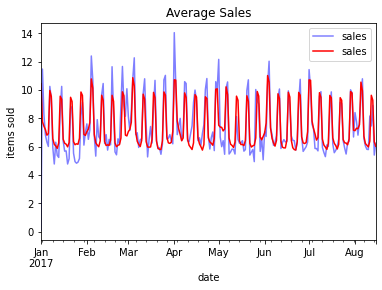

In [90]:
model = LinearRegression().fit(X, y)
y_pred = pd.DataFrame(
    model.predict(X),
    index=X.index,
    columns=y.columns,
)

ax = y.loc['2017'].plot(color='blue', alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.loc['2017'].plot(ax=ax, color='red', label="Seasonal")
ax.legend();

(-4.0, 4.0)

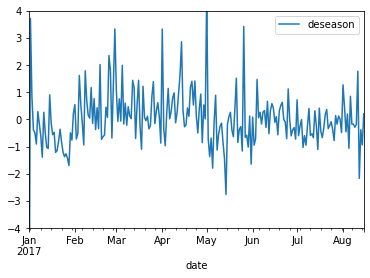

In [91]:
y_deseason = y - y_pred
y_deseason.columns = ['deseason']
y_deseason.plot()
plt.ylim([-4, 4])

In [92]:
# add deseasonalized daily sales to original dataframe
df_auto = pd.merge(df_auto[df_auto['date'].dt.year == 2017], y_deseason.reset_index(), how='left', on='date', suffixes=(None, None))
df_auto

,date,family,sales,onpromotion,type,cluster,is_workday,NewYearsDay,deseason
0,2017-01-01,AUTOMOTIVE,0.0,0,D,13,True,True,-10.356948
1,2017-01-01,AUTOMOTIVE,0.0,0,C,15,True,True,-10.356948
2,2017-01-01,AUTOMOTIVE,0.0,0,B,6,True,True,-10.356948
3,2017-01-01,AUTOMOTIVE,0.0,0,C,15,True,True,-10.356948
4,2017-01-01,AUTOMOTIVE,0.0,0,C,15,True,True,-10.356948
...,...,...,...,...,...,...,...,...,...
12469,2017-08-15,AUTOMOTIVE,8.0,7,C,3,True,False,0.207740
12470,2017-08-15,AUTOMOTIVE,7.0,5,D,13,True,False,0.207740
12471,2017-08-15,AUTOMOTIVE,5.0,4,D,8,True,False,0.207740
12472,2017-08-15,AUTOMOTIVE,4.0,4,D,8,True,False,0.207740


In [99]:
X = df_auto.drop(['date', 'family', 'sales'], axis=1)
X['type'] = X['type'].cat.codes
X['cluster'] = X['cluster'].cat.codes

y = df_auto[['sales']]

xgb = XGBRegressor()
xgb.fit(X, y)


In [121]:
# y_pred = pd.DataFrame(
#     xgb.predict(X),
#     index=X.index,
#     columns=y.columns,
# )


y_pred = xgb.predict(X)

RMSE_fit = sqrt(mean_squared_error(y['sales'], y_pred))
RMSE_fit


2.0462314671520145

## Create separate models for each families

In [177]:
class BoostedHybrid:

    def __init__(self, model_1, model_2) -> None:
        self.model_1 = model_1
        self.model_2 = model_2


    def fit(self, X_1, X_2, y_1, y_2):
        
        # fit first model
        self.model_1.fit(X_1, y_1)
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index,
            columns=['res'],
        )
        y_fit.index.rename('date', inplace=True)

        # merge with original dataframe
        X_2 = pd.merge(X_2, y_fit.reset_index(), how='left', on='date', suffixes=(None, None))
        # drop unused columns
        X_2 = X_2.drop(['date'], axis=1) 

        # fit second model to residuals
        self.model_2.fit(X_2, y_2)


    def predict(self, X_1, X_2):
        # predict with first model
        y_pred_1 = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index,
            columns=['res'],
        )
        y_pred_1.index.rename('date', inplace=True)

        # merge with original dataframe
        X_2 = pd.merge(X_2, y_pred_1.reset_index(), how='left', on='date', suffixes=(None, None))
        # drop unused columns
        X_2 = X_2.drop(['date'], axis=1) 

        # predict with second model
        y_pred_2 = self.model_2.predict(X_2)

        return y_pred_2
        

In [189]:
# utility functions

def get_deterministic_process(index):
    fourier = CalendarFourier(freq='M', order=4)
    dp = DeterministicProcess(
        index=index,
        constant=True,
        order=1,
        seasonal=True,
        additional_terms=[fourier],
        drop=True,
    )
    return dp

def prepare_dataframe(df, family):
    """ Filters rows and columns. """
    
    # use only 2017 data for training
    df_ = df[df['date'].dt.year == 2017]
    # filter dataset
    df_ = df_[df_['family'] == family]
    # drop unused columns
    df_ = df_.drop(['family'], axis=1)  

    return df_  


def get_features_and_target(df, predict=False):
    """ Returns model_2 features (X_2) and target (y_2). """

    df_ = df.copy()
    # encode categoricals
    df_['type'] = df_['type'].cat.codes
    df_['cluster'] = df_['cluster'].cat.codes
    # drop id column
    df_ = df_.drop(['id'], axis=1)

    X = df_
    y = None

    if not predict:
        # no sales column in test dataset
        X = df_.drop(['sales'], axis=1)
        y = df_['sales']

    return X, y


def save_dataframe(df, family):
    """ Converts family name and saves dataframe. """
    name = family.replace('/', '')
    df.to_pickle(f'../dataframes/{name}.pkl')

def load_dataframe(family):
    """ Converts family name and loads dataframe. """
    name = family.replace('/', '')
    df = pd.read_pickle(f'../dataframes/{name}.pkl')
    return df

def save_model(model, family):
    """ Converts family name and saves model. """
    name = family.replace('/', '')
    joblib.dump(model, f'../models/{name}.sav')

def load_model(family):
    """ Converts family name and loads model. """
    name = family.replace('/', '')
    model = joblib.load(f'../models/{name}.sav')
    return model

def save_deterministic_process(dp):
    joblib.dump(model, f'../models/DeterministicProcess.sav')

In [147]:
# get deterministic process and save
dates = sorted(df[df['date'].dt.year == 2017].date.unique())
dp = get_deterministic_process(dates)
save_deterministic_process(dp)

# save dataframe
df.to_pickle(f'../dataframes/df.pkl')

In [182]:
families = df.family.unique()

models = {}

for family in families:
    # filter dataset
    print(f'{family}: preparing...')
    df_ = prepare_dataframe(df, family)

    # create model
    model = BoostedHybrid(LinearRegression(), XGBRegressor())

    # target series for first model = average daily sales
    y_1 = (
        df_
        .groupby(['date']).mean()
        .squeeze()
    )[['sales']]
    # Features for Linear Regression
    X_1 = dp.in_sample()
    # Features for XGBoost
    X_2, y_2 = get_features_and_target(df_, predict=False)

    # train model
    print(f'{family}: train model...')
    model.fit(X_1, X_2, y_1, y_2)
    
    # save model
    print(f'{family}: save model...')
    save_model(model, family)
    models[family] = model

    # predict
    y_pred = model.predict(X_1, X_2)
    # calculate RMSE
    RMSE_fit = sqrt(mean_squared_error(y_2, y_pred))
    print(f'{family}: train RMSE = {RMSE_fit:.2f}')


AUTOMOTIVE: preparing...
AUTOMOTIVE: train model...
AUTOMOTIVE: save model...
AUTOMOTIVE: train RMSE = 2.01
BABY CARE: preparing...
BABY CARE: train model...
BABY CARE: save model...
BABY CARE: train RMSE = 0.26
BEAUTY: preparing...
BEAUTY: train model...
BEAUTY: save model...
BEAUTY: train RMSE = 1.99
BEVERAGES: preparing...
BEVERAGES: train model...
BEVERAGES: save model...
BEVERAGES: train RMSE = 611.98
BOOKS: preparing...
BOOKS: train model...
BOOKS: save model...
BOOKS: train RMSE = 0.23
BREAD/BAKERY: preparing...
BREAD/BAKERY: train model...
BREAD/BAKERY: save model...
BREAD/BAKERY: train RMSE = 77.60
CELEBRATION: preparing...
CELEBRATION: train model...
CELEBRATION: save model...
CELEBRATION: train RMSE = 4.98
CLEANING: preparing...
CLEANING: train model...
CLEANING: save model...
CLEANING: train RMSE = 259.37
DAIRY: preparing...
DAIRY: train model...
DAIRY: save model...
DAIRY: train RMSE = 120.93
DELI: preparing...
DELI: train model...
DELI: save model...
DELI: train RMSE = 63

# Create submission file

In [184]:
# load test dataset
usecols=['id', 'date', 'store_nbr', 'family', 'onpromotion']
dtype = {
    'id': str,
    'store_nbr': 'category',
    'family': 'category',
    'onpromotion': 'uint64',
}

df_sales_test = pd.read_csv(
    '../data/test.csv',
    usecols=usecols,
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_sales_test['date'] = df_sales_test.date.dt.to_period('D')
df_sales_test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,20
1,3000889,2017-08-16,1,BABY CARE,1
2,3000890,2017-08-16,1,BEAUTY,8
3,3000891,2017-08-16,1,BEVERAGES,560
4,3000892,2017-08-16,1,BOOKS,1
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,54
28508,3029396,2017-08-31,9,PREPARED FOODS,10
28509,3029397,2017-08-31,9,PRODUCE,302
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,15


In [185]:
# join test to stores
df_sales_test = pd.merge(df_sales_test, df_stores, how='left', on='store_nbr')
df_sales_test

,id,date,store_nbr,family,onpromotion,city,state,type,cluster
0,3000888,2017-08-16,1,AUTOMOTIVE,20,Quito,Pichincha,D,13
1,3000889,2017-08-16,1,BABY CARE,1,Quito,Pichincha,D,13
2,3000890,2017-08-16,1,BEAUTY,8,Quito,Pichincha,D,13
3,3000891,2017-08-16,1,BEVERAGES,560,Quito,Pichincha,D,13
4,3000892,2017-08-16,1,BOOKS,1,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,54,Quito,Pichincha,B,6
28508,3029396,2017-08-31,9,PREPARED FOODS,10,Quito,Pichincha,B,6
28509,3029397,2017-08-31,9,PRODUCE,302,Quito,Pichincha,B,6
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,15,Quito,Pichincha,B,6


In [187]:
# join to test dataset
df_sales_test_ = pd.merge(df_sales_test, df_holidays, how='left', left_on='date', right_index=True)
df_sales_test_['is_workday'] = True
# get national holidays
df_sales_test_.loc[(df_sales_test_.is_holiday) & (df_sales_test_.locale == 'National'), 'is_workday'] = False
# get local holidays
df_sales_test_.loc[(df_sales_test_.is_holiday) & (df_sales_test_.locale == 'Local') & (df_sales_test_.city.astype('string') == df_sales_test_.locale_name.astype('string')), 'is_workday'] = False
# get regional holidays
df_sales_test_.loc[(df_sales_test_.is_holiday) & (df_sales_test_.locale == 'Regional') & (df_sales_test_.state.astype('string') == df_sales_test_.locale_name.astype('string')), 'is_workday'] = False

# new year is special
df_sales_test_['NewYearsDay'] = (df_sales_test_.date.dt.dayofyear == 1)

# keep neccessary columns
df_test = df_sales_test_.drop(['store_nbr', 'city', 'state', 'holiday_type', 'locale', 'locale_name', 'transferred', 'is_holiday'], axis=1)

df_test

,id,date,family,onpromotion,type,cluster,is_workday,NewYearsDay
0,3000888,2017-08-16,AUTOMOTIVE,20,D,13,True,False
1,3000889,2017-08-16,BABY CARE,1,D,13,True,False
2,3000890,2017-08-16,BEAUTY,8,D,13,True,False
3,3000891,2017-08-16,BEVERAGES,560,D,13,True,False
4,3000892,2017-08-16,BOOKS,1,D,13,True,False
...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,POULTRY,54,B,6,True,False
28508,3029396,2017-08-31,PREPARED FOODS,10,B,6,True,False
28509,3029397,2017-08-31,PRODUCE,302,B,6,True,False
28510,3029398,2017-08-31,SCHOOL AND OFFICE SUPPLIES,15,B,6,True,False


In [166]:
steps = df_test.date.nunique()

In [190]:
# create prediction
families = df_test.family.unique()

predictions = pd.DataFrame(columns=['id', 'sales'])

for family in families:
    # filter dataset
    print(f'{family}: preparing...')
    df_ = prepare_dataframe(df_test, family)

    # create model
    model = models[family]

    # Features for Linear Regression
    X_1 = dp.out_of_sample(steps=steps)
    # Features for XGBoost
    X_2, _ = get_features_and_target(df_, predict=True)

    # predict
    print(f'{family}: predicting...')
    y_pred = pd.DataFrame(
        model.predict(X_1, X_2),
        index=df_.index,
        columns=['sales']
    )
    y_pred['id'] = df_['id']

    predictions = pd.concat([predictions, y_pred], axis=0)


# save predictions dataframe
predictions.to_pickle(f'../dataframes/predictions.pkl')
predictions

AUTOMOTIVE: preparing...
AUTOMOTIVE: predicting...
BABY CARE: preparing...
BABY CARE: predicting...
BEAUTY: preparing...
BEAUTY: predicting...
BEVERAGES: preparing...
BEVERAGES: predicting...
BOOKS: preparing...
BOOKS: predicting...
BREAD/BAKERY: preparing...
BREAD/BAKERY: predicting...
CELEBRATION: preparing...
CELEBRATION: predicting...
CLEANING: preparing...
CLEANING: predicting...
DAIRY: preparing...
DAIRY: predicting...
DELI: preparing...
DELI: predicting...
EGGS: preparing...
EGGS: predicting...
FROZEN FOODS: preparing...
FROZEN FOODS: predicting...
GROCERY I: preparing...
GROCERY I: predicting...
GROCERY II: preparing...
GROCERY II: predicting...
HARDWARE: preparing...
HARDWARE: predicting...
HOME AND KITCHEN I: preparing...
HOME AND KITCHEN I: predicting...
HOME AND KITCHEN II: preparing...
HOME AND KITCHEN II: predicting...
HOME APPLIANCES: preparing...
HOME APPLIANCES: predicting...
HOME CARE: preparing...
HOME CARE: predicting...
LADIESWEAR: preparing...
LADIESWEAR: predicti

,id,sales
0,3000888,28.151855
33,3000921,28.615496
66,3000954,28.752556
99,3000987,28.615496
132,3001020,28.615496
...,...,...
28379,3029267,19.669538
28412,3029300,29.462225
28445,3029333,72.296471
28478,3029366,72.296471


In [196]:
ver = f'{datetime.datetime.now():%Y%m%d%H%M%S}'
predictions.sort_values('id', inplace=True)
predictions.to_csv(f'../submissions/submission_{ver}.csv', index=False)